In [1]:
from layered_atmosphere import (LayeredAtmosphere, AtmosphericLayer, RandomAtmosphere,
                                NoisyLayeredAtmosphere, RandomNoisyAtmosphere, RandomLayer,
                                ConstantSampler, UniformSampler, GaussianSamplerBetween)
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import norm

plain international standard atmosphere

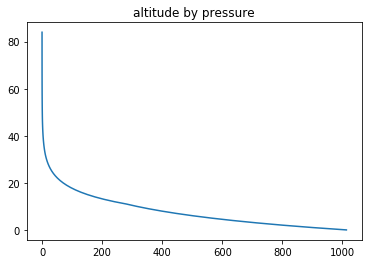

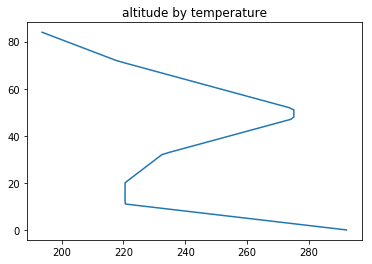

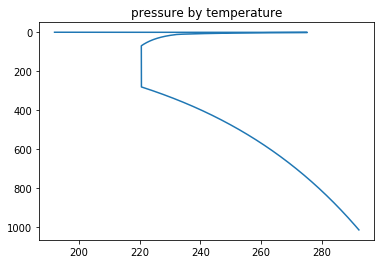

In [2]:
atm = LayeredAtmosphere.international_standard_atmosphere()

alts = np.arange(0, atm.height, 1)
temps = [atm.get_temperature_by_altitude(a) for a in alts]
press = [atm.get_pressure_by_altitude(a) / 100 for a in alts]

min_ps = atm.get_pressure_by_altitude(atm.height)
pss = np.arange(min_ps / 100, 1013.25, 0.1)
tss = [atm.get_temperature_by_pressure(p * 100) for p in pss]

plt.title('altitude by pressure'); plt.plot(press, alts); plt.show()
plt.title('altitude by temperature'); plt.plot(temps, alts); plt.show()
plt.title('pressure by temperature'); plt.plot(tss, pss); plt.gca().invert_yaxis(); plt.show()

generate new atmospheres by randomly changing height and lapse rate of each layer, as well as surface temperature and pressure

In [3]:
gas_const = ConstantSampler(0.28704)
rnd = RandomAtmosphere(
    GaussianSamplerBetween(273 - 100, 273 + 60),
    GaussianSamplerBetween(87000, 110000),
    RandomLayer(UniformSampler(5, 25),  GaussianSamplerBetween(-10, -0.1), gas_const),
    RandomLayer(UniformSampler(0.1, 3), GaussianSamplerBetween(-1, 1), gas_const),
    RandomLayer(UniformSampler(8, 16),  GaussianSamplerBetween(1, 2), gas_const),
    RandomLayer(UniformSampler(11, 19), GaussianSamplerBetween(2, 3), gas_const),
    RandomLayer(UniformSampler(1, 7),   GaussianSamplerBetween(-1, 1), gas_const),
    RandomLayer(UniformSampler(15, 25), GaussianSamplerBetween(-5, -0.1), gas_const),
    RandomLayer(UniformSampler(10, 20), GaussianSamplerBetween(-5, -0.1), gas_const),
)
rnd.sample()

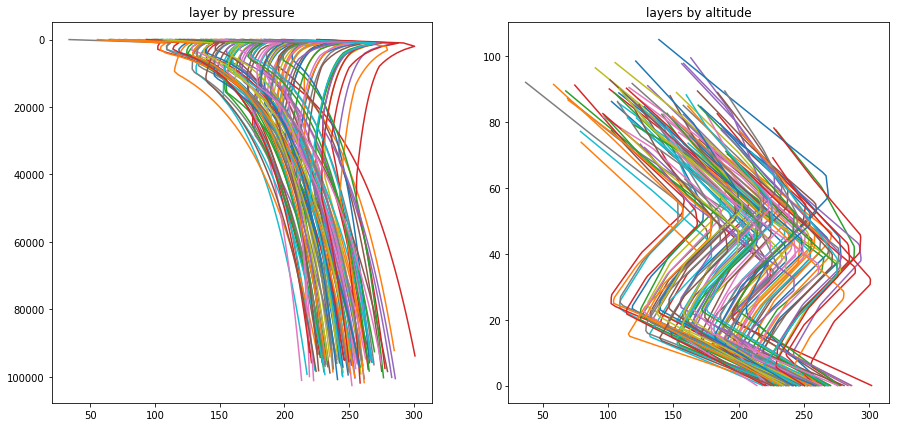

In [4]:
def plot_random_samples(rnd, count):
    plt.figure(figsize=(15, 7))
    for _ in range(count):
        ratm = rnd.sample()
        max_ps = ratm.get_pressure_by_altitude(0.1) * 0.9999
        min_ps = ratm.get_pressure_by_altitude(ratm.height) * 1.0001

        plt.subplot(1, 2, 1)
        pss = np.arange(min_ps, max_ps, (max_ps - min_ps) / 100)
        tss = [ratm.get_temperature_by_pressure(p) for p in pss]
        plt.plot(tss, pss)

        plt.subplot(1, 2, 2)
        alts = np.arange(0, ratm.height, ratm.height / 100)
        temps = [ratm.get_temperature_by_altitude(a) for a in alts]
        plt.plot(temps, alts)

    plt.subplot(1, 2, 1)
    plt.title('layer by pressure')
    plt.gca().invert_yaxis()
    plt.subplot(1, 2, 2)
    plt.title('layers by altitude')
    plt.show()


plot_random_samples(rnd, 100)

the fact that the starting altitude in the right plot seems to increase with the temperature is just an optical illusion

now add some noise to the temperature as follows:

$$
T^\prime(h)=T(h)+a\cdot\frac{\sin(h+b)}{\sqrt{h+c}}
$$

where $h$ is the altitude (km), and $a$, $b$ and $c$ some coefficients.

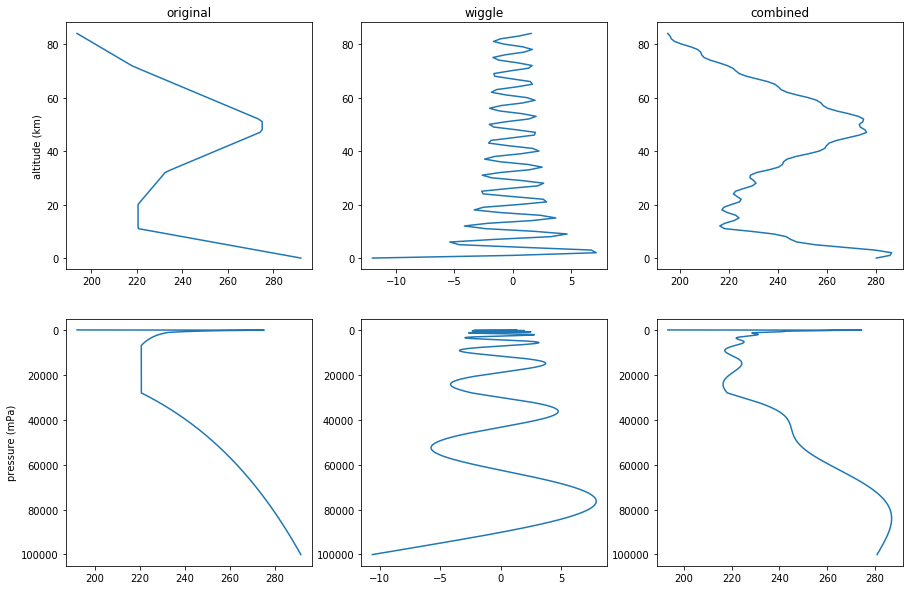

In [5]:
def display_wiggle(make_wiggle):
    atm = LayeredAtmosphere().international_standard_atmosphere()
    alts = np.arange(0, atm.height, 1)
    temps = list(map(atm.get_temperature_by_altitude, alts))
    mod = list(map(make_wiggle, alts))

    plt.figure(figsize=(15, 10))
    plt.subplot(2, 3, 1); plt.title('original')
    plt.plot(temps, alts)
    plt.ylabel('altitude (km)')
    plt.subplot(2, 3, 2); plt.title('wiggle')
    plt.plot(mod, alts)
    plt.subplot(2, 3, 3); plt.title('combined')
    plt.plot([m + t for m, t in zip(mod, temps)], alts)

    max_ps = atm.get_pressure_by_altitude(0.1)
    min_ps = atm.get_pressure_by_altitude(atm.height)
    press = np.arange(min_ps, max_ps, (max_ps - min_ps) / 1000)
    temps_alts = [(
        atm.get_temperature_by_pressure(p),
        atm.get_altitude_by_pressure(p)
    ) for p in press]
    mod = [make_wiggle(a) for _, a in temps_alts]

    plt.subplot(2, 3, 4)
    plt.plot([t for t, _ in temps_alts], press)
    plt.gca().invert_yaxis()
    plt.ylabel('pressure (mPa)')
    plt.subplot(2, 3, 5)
    plt.plot(mod, press)
    plt.gca().invert_yaxis()
    plt.subplot(2, 3, 6)
    plt.plot([m + t for m, (t, _) in zip(mod, temps_alts)], press)
    plt.gca().invert_yaxis()
    plt.show()


display_wiggle(lambda alt: 15 * np.sin(alt - 1) / np.sqrt(alt + 1.1))

here are some more samples

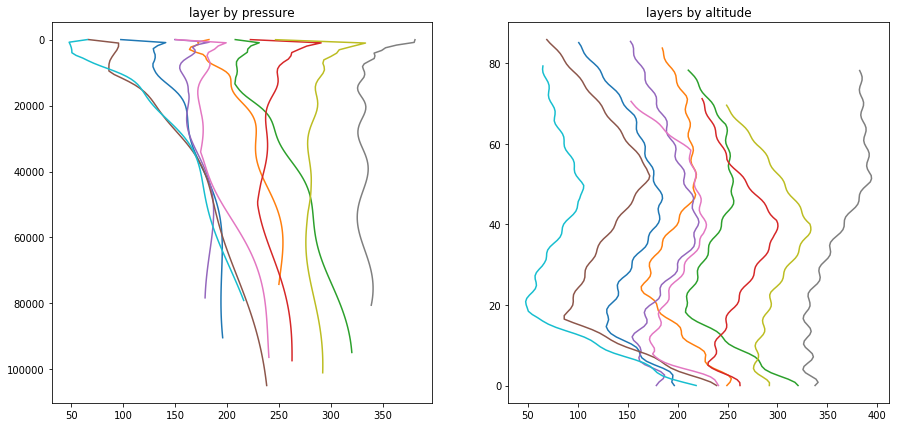

In [6]:
# uses the same noise form shown above, with random coefficients
rnd = RandomNoisyAtmosphere(
    RandomAtmosphere(
        UniformSampler(273 - 100, 273 + 60),
        UniformSampler(70000, 110000),
        RandomLayer(UniformSampler(5, 25),  UniformSampler(-10, -0.1), gas_const),
        RandomLayer(UniformSampler(0.1, 3), UniformSampler(-1, 1), gas_const),
        RandomLayer(UniformSampler(8, 16),  UniformSampler(1, 2), gas_const),
        RandomLayer(UniformSampler(11, 19), UniformSampler(2, 3), gas_const),
        RandomLayer(UniformSampler(1, 7),   UniformSampler(-1, 1), gas_const),
        RandomLayer(UniformSampler(15, 25), UniformSampler(-5, -0.1), gas_const),
        RandomLayer(UniformSampler(10, 20), UniformSampler(-5, -0.1), gas_const),
    ),
    GaussianSamplerBetween(5, 25),
    GaussianSamplerBetween(-5, 5),
    GaussianSamplerBetween(1, 5),
)


plot_random_samples(rnd, 10)

to generate the humidity, we will randomly generate the relative humidity, then convert to absolute humidity

we first show some historic samples to get an idea on how the relative humidity changes with altitude

In [7]:
import os
import random
from netCDF4 import Dataset
from metpy.calc import saturation_mixing_ratio
from metpy.units import units as unit_reg


def cal_air_pressure(air_pressure_interface):
    air_pressure = np.empty(60)
    for level in range(len(air_pressure_interface) - 1):
        air_pressure[level] = (air_pressure_interface[level] + air_pressure_interface[level+1])*0.5
    return air_pressure


def all_historical_samples():
    path = !pwd
    dset_path = os.path.join(path[0], 'radiation/historical_dataset/')
    
    for fname in os.listdir(dset_path):
        if not fname.endswith('.nc'):
            continue

        f = Dataset(os.path.join(dset_path, fname), mode='r')
        v = f.variables['radiation_data'][:]
        f.close()

        sid = np.random.choice(v.shape[0], size=1)[0]
        
        for sid in v:
            air_temperature = sid[2:62]
            specific_humidity = sid[62:122]
            air_pressure = cal_air_pressure(sid[182:263])

            yield  air_pressure, air_temperature, specific_humidity


all_samples = list(all_historical_samples())

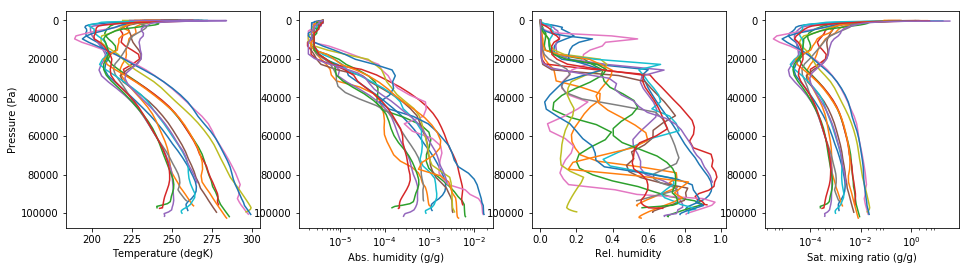

In [8]:
random.shuffle(all_samples)

plt.figure(figsize=(16, 4))
for press, temp, hum in all_samples[:15]:
    sathum = saturation_mixing_ratio(
        press * unit_reg('Pa'), temp * unit_reg('degK')
    ).to('g/g')
    relhum = hum / sathum

    
    plt.subplot(1, 4, 1)
    plt.plot(temp, press)
    plt.subplot(1, 4, 2)
    plt.semilogx(hum, press)
    plt.subplot(1, 4, 3)
    plt.plot(relhum, press)
    plt.subplot(1, 4, 4)
    plt.semilogx(sathum, press)

    
plt.subplot(1, 4, 1)
plt.gca().invert_yaxis()
plt.xlabel('Temperature (degK)')
plt.ylabel('Pressure (Pa)')
plt.subplot(1, 4, 2)
plt.gca().invert_yaxis()
plt.xlabel('Abs. humidity (g/g)')
plt.subplot(1, 4, 3)
plt.gca().invert_yaxis()
plt.xlabel('Rel. humidity')
plt.subplot(1, 4, 4)
plt.gca().invert_yaxis()
plt.xlabel('Sat. mixing ratio (g/g)')
    
plt.show()

RH seems pretty much random

In [9]:
from sklearn.svm import SVR


def random_relative_humidity(pmin, pmax, num_support_vectors=10, num_samples=100,
                             samples_x=None, svr_c=2, svr_gamma=1e-8):

    # basically generate random points and fit an SVR to them, then predict some samples
    # and scale the output so that it shows a decreasing trend, with  0% RH at the top of the atmosphere

    pts_x = np.array([pmin] + sorted(
        pmin + np.random.random(size=num_support_vectors) * (pmax - pmin)
    ) + [pmax])
    pts_y = np.random.random(size=len(pts_x))

    if samples_x is None:
        fn_x = np.arange(pmin, pmax, (pmax - pmin) / num_samples)
    else:
        fn_x = samples_x

    sx = (fn_x - fn_x.min()) / (fn_x.max() - fn_x.min())
    of = 0.2 +  np.random.random() * 0.3
    btop = 1 / (1 + np.exp(-(sx - of) * 25))
    
    bbot = fn_x / pmax * 0.1

    svr = SVR(C=svr_c, gamma=svr_gamma).fit(pts_x.reshape((-1, 1)), pts_y)
    fn_y = svr.predict(fn_x.reshape((-1, 1)))
    fn_y = np.where(fn_y < 0.01, 0.01, fn_y)
    fn_y = np.where(fn_y > 0.99, 0.99, fn_y)
    fn_y = bbot + fn_y * (btop - bbot)

    return fn_x, fn_y

these are the two top boundaries

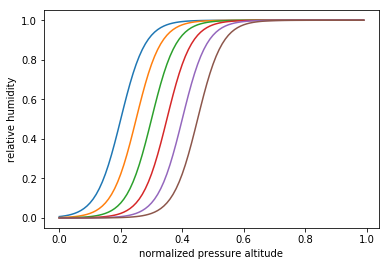

In [10]:
sx = np.arange(0, 1, 1 / 100)

for of in np.arange(0.2, 0.5, 0.05):
    by = 1 / (1 + np.exp(-(sx - of) * 25))
    plt.plot(sx, by)

plt.xlabel('normalized pressure altitude')
plt.ylabel('relative humidity')
plt.show()

next we show some synthetic (top) and real (bottom) relative humidity profiles

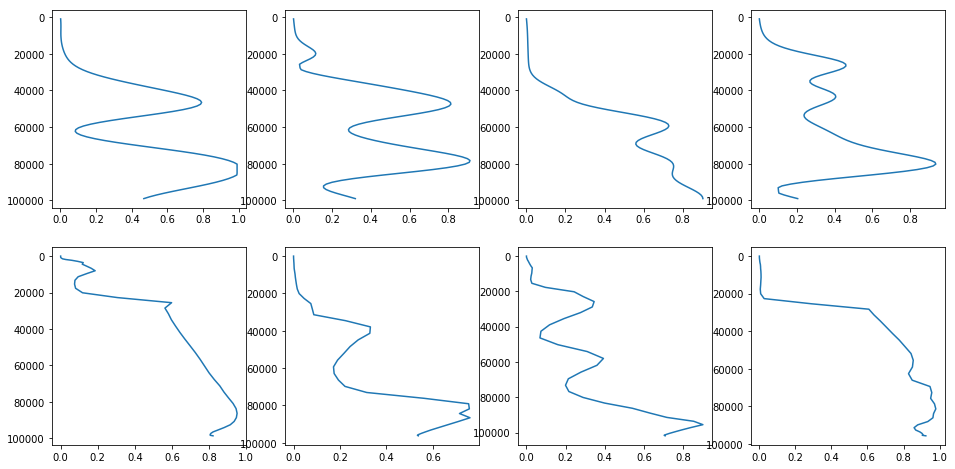

In [11]:
# plot synthetic samples
plt.figure(figsize=(16, 8))
for i in range(4):
    fn_x, fn_y = random_relative_humidity(1000, 100000)

    plt.subplot(2, 4, i + 1)
    plt.plot(fn_y, fn_x)
    plt.gca().invert_yaxis()


# plot historical samples
for i, (press, temp, hum) in enumerate(all_samples[:4]):
    sathum = saturation_mixing_ratio(
        press * unit_reg('Pa'), temp * unit_reg('degK')
    ).to('g/g')
    relhum = hum / sathum
    
    plt.subplot(2, 4, 4 + i + 1)
    plt.gca().invert_yaxis()
    plt.plot(relhum, press)
    plt.xlabel('')

plt.show()

in order to compute the absolute humidity, we have to compute the saturation pressure first. we compare our computations with those deriving from metpy to make sure we got the formula correct

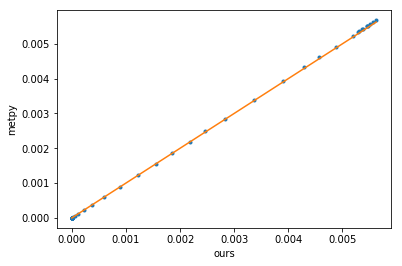

In [12]:
def compute_absolute_humidity(relative_humidity, temperature, pressure):
    tempC = temperature - 273.15  # convert to deg C

    # buck equation, result in Pa
    saturation_press = 1000 * 0.61121 * np.exp((18.678 - tempC / 234.5) * (tempC / (257.14 + tempC)))
    
    # eq. 3.63 p 82
    abs_humidity = 0.622 * relative_humidity * saturation_press / pressure

    return np.where(abs_humidity < 0, 0, abs_humidity)


cah = compute_absolute_humidity(relhum, temp, press)
plt.plot(cah, hum, '.')
plt.xlabel('ours')
plt.ylabel('metpy')

liminf = min(cah.max(), hum.max())
plt.plot([0, liminf], [0, liminf])

we are finally ready to generate synthetic samples

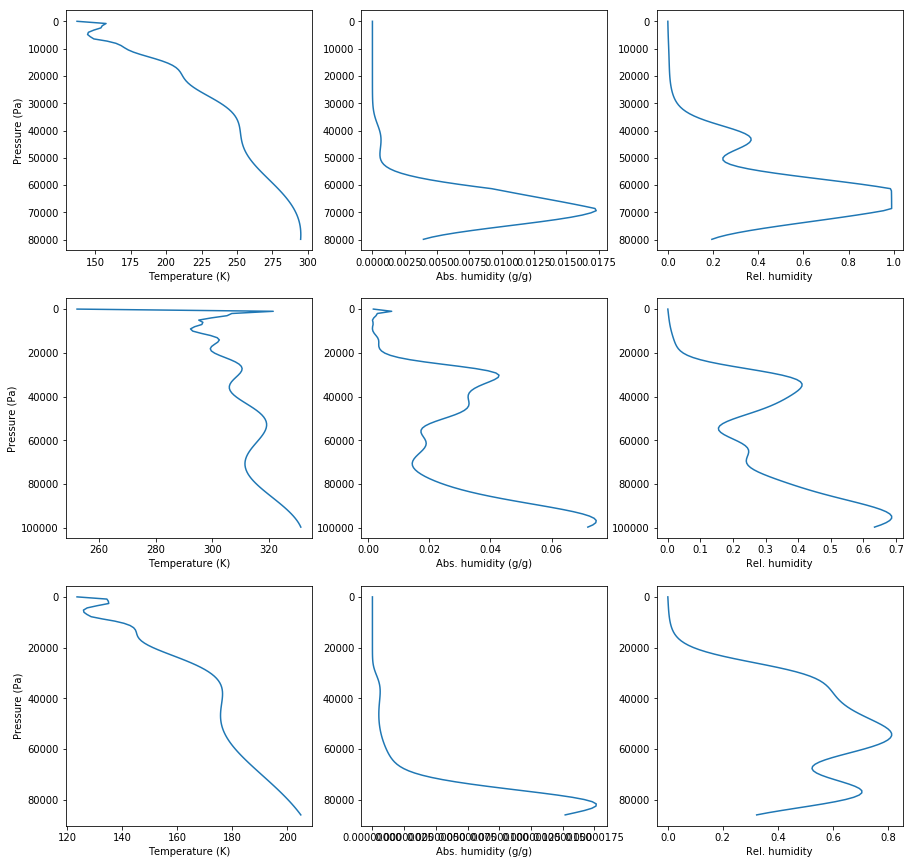

In [13]:
plt.figure(figsize=(15, 15))
for i in range(3):
    ratm = rnd.sample()
    max_ps = ratm.get_pressure_by_altitude(0.1) * 0.9999
    min_ps = ratm.get_pressure_by_altitude(ratm.height) * 1.0001

    press = np.arange(min_ps, max_ps, (max_ps - min_ps) / 100)
    temps = np.array([ratm.get_temperature_by_pressure(p) for p in press])

    _, relhum = random_relative_humidity(min_ps, max_ps, samples_x=press)

    abshum = compute_absolute_humidity(relhum, temps, press)

    plt.subplot(3, 3, 3 * i + 1)
    plt.plot(temps, press)
    plt.ylabel('Pressure (Pa)')
    plt.xlabel('Temperature (K)')
    plt.gca().invert_yaxis()
    plt.subplot(3, 3, 3 * i + 2)
    plt.plot(abshum, press)
    plt.gca().invert_yaxis()
    plt.xlabel('Abs. humidity (g/g)')
    plt.subplot(3, 3, 3 * i + 3)
    plt.plot(relhum, press)
    plt.gca().invert_yaxis()
    plt.xlabel('Rel. humidity')
plt.show()

<IPython.core.display.Javascript object>


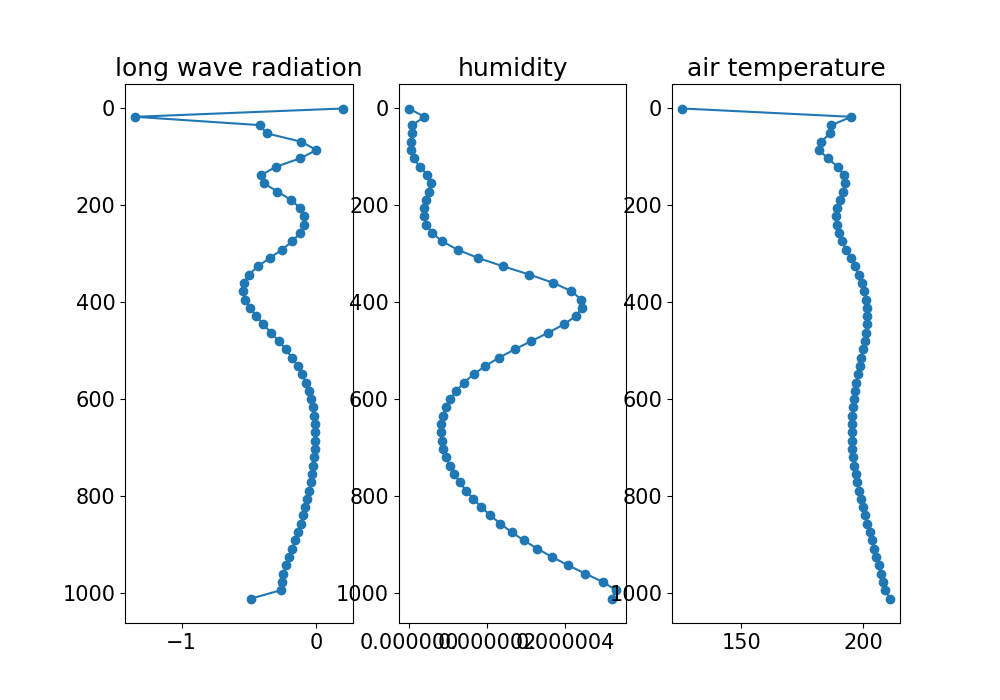

KeyboardInterrupt: 

In [14]:
%matplotlib notebook

from sympl import DataArray, PlotFunctionMonitor, RelaxationPrognostic, AdamsBashforth
from climt import SimplePhysics, get_default_state
import numpy as np
from datetime import timedelta
import random
import pickle
import os
from scipy.interpolate import CubicSpline
from climt import EmanuelConvection, RRTMGShortwave, RRTMGLongwave, SlabSurface
import time
from netCDF4 import Dataset
import matplotlib.pyplot as plt
from matplotlib.pyplot import rcParams
from copy import deepcopy
from sklearn.metrics import mean_squared_error

rcParams['figure.figsize'] = 10, 10
rcParams['font.size'] = 15


def cal_air_pressure(air_pressure_interface):
    air_pressure = np.empty(60)
    for level in range(len(air_pressure_interface) - 1):
        air_pressure[level] = (air_pressure_interface[level] + air_pressure_interface[level+1])*0.5
    return air_pressure


def plot_function(fig, state):
    fig.set_size_inches(10, 7)

    ax = fig.add_subplot(1, 3, 1)
    ax.plot(
        state['longwave_heating_rate'].values.flatten(),
        state['air_pressure'].to_units('mbar').values.flatten(), '-o'
    )
    ax.set_title("long wave radiation")
    ax.axes.invert_yaxis()

    ax = fig.add_subplot(1, 3, 2)
    ax.plot(
        state['specific_humidity'].values.flatten(),
        state['air_pressure'].to_units('mbar').values.flatten(), '-o')
    ax.set_title("humidity")
    ax.axes.invert_yaxis()

    ax = fig.add_subplot(1, 3, 3)
    ax.plot(
        state['air_temperature'].values.flatten(),
        state['air_pressure'].to_units('mbar').values.flatten(), '-o')
    ax.set_title("air temperature")
    ax.axes.invert_yaxis()


def get_interface_pressures(p, ps):
    """Given 3D pressure on model mid levels (cell centers) and the 2D surface
    pressure, return the 3D pressure on model full levels (cell interfaces).
    If the z-dimension of p is length K, the returned p_full will have a
    z-dimension of length K+1."""
    interface_pressures = np.zeros(
        (p.shape[0], p.shape[1], p.shape[2] + 1), dtype=np.double)
    interface_pressures[:, :, 1:-1] = 0.5 * (p[:, :, 1:] + p[:, :, :-1])
    interface_pressures[:, :, 0] = ps[:, :]
    return interface_pressures


def initial_state(random_atmosphere):
    
    ratm = rnd.sample()

    max_ps = ratm.get_pressure_by_altitude(0.1) * 0.9999
    min_ps = ratm.get_pressure_by_altitude(ratm.height) * 1.0001
    pressure = np.arange(min_ps, max_ps, (max_ps - min_ps) / 60)
    
    interface_pressure = np.zeros((len(pressure) + 1), dtype=np.double)
    interface_pressure[1:-1] = 0.5 * (pressure[1:] + pressure[:-1])
    
    temps = np.array([ratm.get_temperature_by_pressure(p) for p in pressure])
    _, relhum = random_relative_humidity(min_ps, max_ps, samples_x=pressure)
    abshum = compute_absolute_humidity(relhum, temps, pressure)

    state = get_default_state([
        simple_physics, convection, radiation_lw, radiation_sw, slab
    ], mid_levels={
        'label': 'mid_levels',
        'values': np.arange(len(pressure)),
        'units': ''
    }, interface_levels={
        'label': 'interface_levels',
        'values': np.arange(len(pressure) + 1),
        'units': ''
    })

    state['surface_albedo_for_direct_shortwave'].values[:] = .5
    state['surface_albedo_for_direct_near_infrared'].values[:] = 0.5
    state['surface_albedo_for_diffuse_shortwave'].values[:] = 0.5
    state['zenith_angle'].values[:] = np.pi/3.
    state['ocean_mixed_layer_thickness'].values[:] = 50.
    state['area_type'].values[:] = 'sea'
    
    #state['air_pressure_on_interface_levels'].values[0, 0] = interface_pressure
    #state['air_pressure'].values[0, 0] = pressure    
    state['air_temperature'].values[0, 0] = temps[::-1]
    state['surface_temperature'].values[:] = ratm.get_temperature_by_altitude(0)
    state['specific_humidity'].values[0, 0] = abshum[::-1]
    
    return state


def simulate(state, timesteps=1000):
    monitor = PlotFunctionMonitor(plot_function)
    timestep = timedelta(minutes=10)

    equilibrium_value = DataArray(
        np.ones((1, 1, len(state['air_pressure']))) * 10,
        dims=('x', 'y', 'mid_levels'),
        attrs={'units': 'm s^-1'}
    )

    tau = DataArray(np.array(2.), dims=[], attrs={'units': 'hour'})

    relaxation = RelaxationPrognostic('eastward_wind', equilibrium_value, tau)
    time_stepper = AdamsBashforth([
        relaxation, convection, radiation_lw, radiation_sw, slab
    ])

    for i in range(timesteps):
        states = []
        convection.current_time_step = timestep
        diagnostics, state = time_stepper(state, timestep)
        state.update(diagnostics)

        new_state, diagnostics = simple_physics(state, timestep)
        state.update(diagnostics)
        monitor.store(state)

        state.update(new_state)
        state['eastward_wind'].values[:] = 6.


convection = EmanuelConvection()
radiation_sw = RRTMGShortwave()
radiation_lw = RRTMGLongwave()
slab = SlabSurface()
simple_physics = SimplePhysics(use_external_surface_specific_humidity=False)
        
simulate(initial_state(rnd))